In [15]:
import rospy
from sensor_msgs.msg import Image
from geometry_msgs.msg import Twist

In [16]:
rospy.init_node('watcher')
def snap():
    return rospy.wait_for_message('/camera/rgb/image_raw', Image, timeout=1.)
cmd_vel_pub = rospy.Publisher('cmd_vel', Twist, queue_size=1)

In [17]:
import cv2, numpy as np
from cv_bridge import CvBridge
from matplotlib import pyplot as plt

(480, 640, 3)


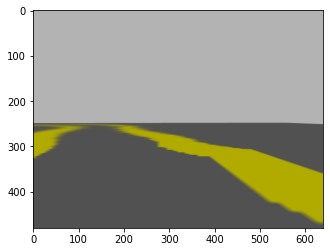

In [270]:
bridge = CvBridge()
def image():
    msg = snap()
    return bridge.imgmsg_to_cv2(msg,desired_encoding='bgr8')
def show(img, **kwargs):
    plt.imshow(img[...,::-1], **kwargs)

img = image()
print(img.shape)
show(img)

Hue:


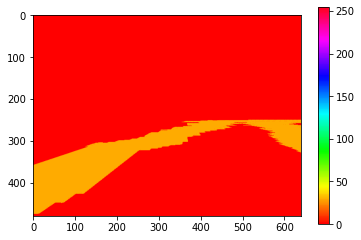

Saturation:


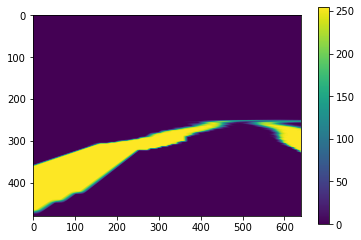

Value:


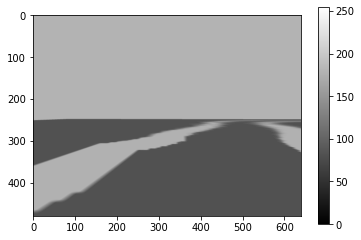

In [271]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, sat, val = np.moveaxis(hsv, -1, 0)

print("Hue:")
show(hue,vmin=0,vmax=255,cmap='hsv')
plt.colorbar()
plt.show()

print("Saturation:")
show(sat,vmin=0,vmax=255)
plt.colorbar()
plt.show()

print("Value:")
show(val,vmin=0,vmax=255,cmap='gray')
plt.colorbar()
plt.show()

In [272]:
import scipy.stats
def pval(dist, points):
    "Returns the p-value of points on a symmetric distribution."
    cumul = dist.cdf(points)
    return 2*np.minimum(cumul, 1-cumul)

def pval_lower(dist, points):
    "Returns the lower p-value of points on a distribution."
    return dist.cdf(points)

def pval_upper(dist, points):
    "Returns the upper p-value of points on a distribution."
    return dist.sf(points)

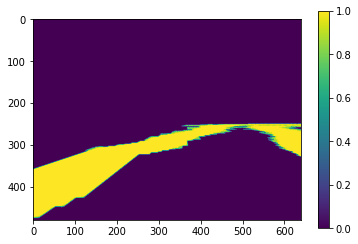

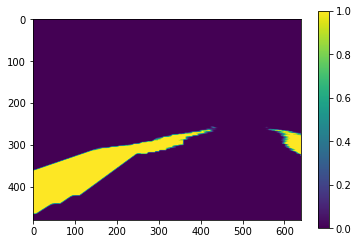

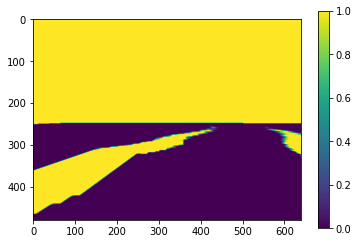

In [273]:
hue_dist = scipy.stats.norm(29, 5)
sat_dist = scipy.stats.expon(0, 5)
val_dist = scipy.stats.expon(78, 5)
inv_tf = lambda x: 255 - x

pval_hue = pval(hue_dist, hue.astype(float))
show(pval_hue, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_sat = pval_upper(sat_dist, inv_tf(sat).astype(float))
show(pval_sat, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_val = pval_upper(val_dist, inv_tf(val).astype(float))
show(pval_val, vmin=0, vmax=1)
plt.colorbar()
plt.show()

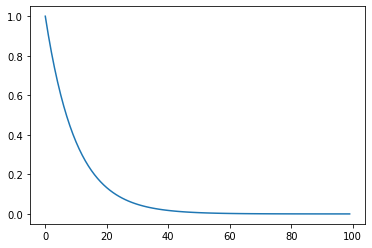

In [274]:
plt.plot(scipy.stats.expon(0,1).pdf(np.linspace(0,10,100)))

(array([26080.,   960.,   807.,   894.,   731.,   849.,   889.,   979.,
         1159.,  2819.]),
 array([ 78. ,  87.6,  97.2, 106.8, 116.4, 126. , 135.6, 145.2, 154.8,
        164.4, 174. ]),
 <BarContainer object of 10 artists>)

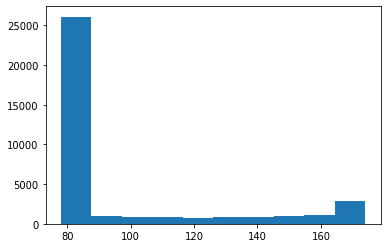

In [275]:
plt.hist(255-val[hue>10],bins=10)

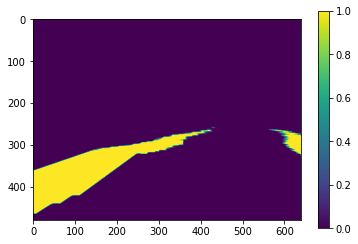

In [276]:
pval_tot = pval_hue * pval_sat *pval_val
show(pval_tot, vmin=0, vmax=1)
plt.colorbar()

In [277]:
def filter(hsv):
    hue, sat, val = np.moveaxis(hsv.astype(float), -1, 0)
    pval_hue = pval(hue_dist, hue)
    pval_sat = pval_upper(sat_dist, inv_tf(sat))
    pval_val = pval_upper(val_dist, inv_tf(val))
    return pval_hue * pval_sat * pval_val

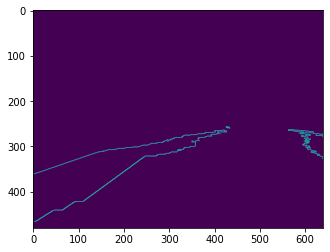

In [278]:
filter_img = (pval_tot * 255).astype(np.uint8)
edges = cv2.Canny(filter_img, 200, 240)
show(edges)

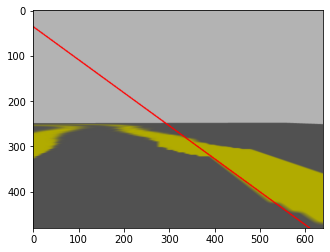

In [279]:
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
lines = cv2.HoughLines(edges, 1, np.pi/180, 60)
if lines is None:
    lines = []
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
show(img)

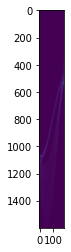

In [280]:
from skimage.transform import hough_line
out, angles, d = hough_line(edges)
show(out)

In [281]:
print(np.min(out), np.max(out), np.mean(out), np.std(out))

0 139 0.956875 2.6786672600251333


In [282]:
print(out.shape)
idx = np.moveaxis(np.indices(out.shape), 0, -1)
print(idx.shape)
hough_filter = out > 20

(1600, 180)
(1600, 180, 2)


In [283]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(idx[hough_filter].reshape(-1,2), sample_weight=out[hough_filter].flat)
centers = kmeans.cluster_centers_
centers

array([[ 624.1773775 ,   17.96906325],
       [1055.14410038,  158.15098158]])

In [284]:
found_angles = np.interp(centers[:,1], np.arange(len(angles)), angles)
found_dist = np.interp(centers[:,0], np.arange(len(d)), d)
print(found_angles)
print(found_dist)

[-1.25542495  1.20487944]
[-175.43226767  255.80397787]


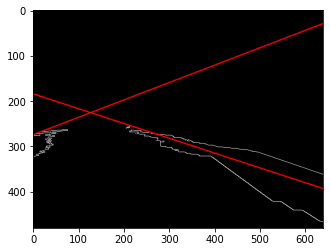

In [285]:
edges_w_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
for rho,theta in zip(found_dist, found_angles):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(edges_w_lines,(x1,y1),(x2,y2),(0,0,255),2)
show(edges_w_lines)

In [286]:
def cluster(filter, n_clusters=2):
    out, angles, d = hough_line(filter)
    idx = np.moveaxis(np.indices(out.shape), 0, -1)
    hough_filter = out > 20
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(idx[hough_filter].reshape(-1,2), sample_weight=out[hough_filter].flat)
    centers = kmeans.cluster_centers_
    found_dist = np.interp(centers[:,0], np.arange(len(d)), d)
    found_angles = np.interp(centers[:,1], np.arange(len(angles)), angles)
    return np.stack([found_dist,found_angles],axis=-1)
cluster(filter_img)

array([[-84.22395585,  -0.98446853],
       [494.23590607,   0.51789642]])

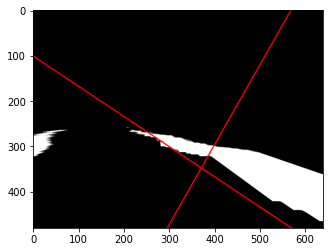

In [287]:
def draw_lines(img, lines):
    for rho,theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
filter_w_lines = cv2.cvtColor(filter_img, cv2.COLOR_GRAY2BGR)
draw_lines(filter_w_lines, cluster(filter_img, n_clusters=2))
show(filter_w_lines)

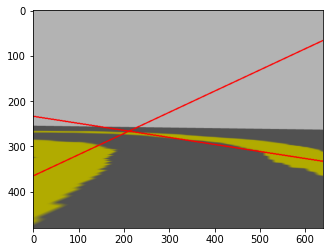

In [297]:
img = image()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
filter_img = (filter(hsv) * 255).astype(np.uint8)
edges = cv2.Canny(filter_img, 200, 240)

draw_lines(img, cluster(edges, n_clusters=2))
show(img)

In [393]:
def angle_dist(a, b):
    "Calculates the acute distance between two angles in degrees."
    dist = (a - b) % (2*np.pi)
    return np.where(dist <= np.pi, dist, 2*np.pi - dist)

def angle_diff(a, b):
    "Calculates the acute difference between two angles in degrees."
    dist = (a - b) % (2*np.pi)
    return np.where(dist <= np.pi, dist, dist - 2*np.pi)

def recenter(angles, mid_angle):
    return np.mod(angles - mid_angle + np.pi, 2*np.pi) + mid_angle - np.pi
    
def idx_to_xy(idx):
    return idx[...,::-1] * (1,-1)
def xy_to_idx(xy):
    return (xy * (1,-1))[...,::-1]

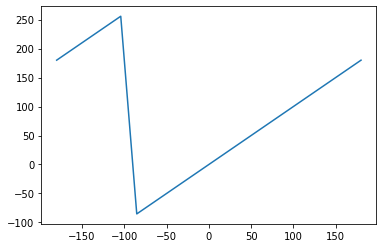

In [338]:
x = np.linspace(-180,180,20)
y = np.rad2deg(recenter(np.deg2rad(x), np.deg2rad(90)))
plt.plot(x,y)

In [376]:
edge_idx = np.moveaxis(np.indices(edges.shape),0,-1)[edges>127].reshape(-1,2)
center = (edges.shape[0],edges.shape[1]/2)
diff_xy = idx_to_xy(edge_idx - center)
edge_rad = recenter(np.arctan2(diff_xy[:,1],diff_xy[:,0]), np.deg2rad(90))
edge_rad

array([2.4890112 , 2.48728423, 2.48554944, ..., 3.09475194, 3.09460532,
       3.09445778])

[465   0] [363 639]


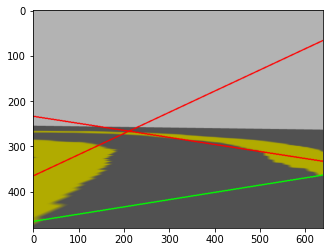

In [377]:
left, right = edge_idx[[np.argmax(edge_rad), np.argmin(edge_rad)]]
print(left, right)
img_w_line = img.copy()
cv2.line(img_w_line, left[::-1], right[::-1], (0,255,0),2)
show(img_w_line)

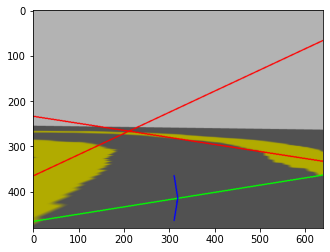

In [389]:
dist = 50

mid = np.mean([left, right],axis=0)
diff_xy = idx_to_xy(right - left)
line_rad = np.arctan2(diff_xy[1], diff_xy[0])
theta = line_rad + np.deg2rad(90)
normal = np.array([np.cos(theta), np.sin(theta)])
next_pt = mid + dist * xy_to_idx(normal)

cv2.line(img_w_line, mid[::-1].astype(int), next_pt[::-1].astype(int), (255,0,0),2)
show(img_w_line)

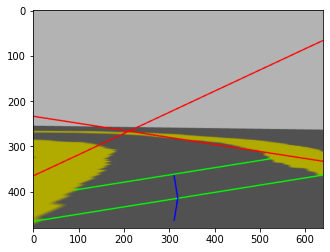

In [403]:
diff_xy = idx_to_xy(edge_idx - next_pt)
edge_rad = np.arctan2(diff_xy[:,1],diff_xy[:,0])
edge_dist = np.linalg.norm(diff_xy,axis=-1)

filter_left = angle_dist(edge_rad, theta + np.deg2rad(90)) < np.deg2rad(1)
left = edge_idx[filter_left][np.argmin(edge_dist[filter_left])]

filter_right = angle_dist(edge_rad, theta - np.deg2rad(90)) < np.deg2rad(1)
right = edge_idx[filter_right][np.argmin(edge_dist[filter_right])]

cv2.line(img_w_line, left[::-1], right[::-1], (0,255,0),2)
show(img_w_line)

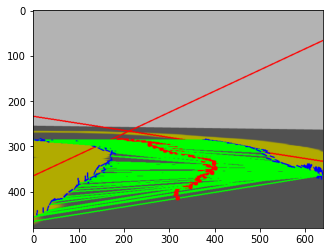

In [441]:
def search_by_angle(diff, angle):
    angles = np.arctan2(diff[:,1],diff[:,0])
    return np.argmin(angle_dist(angles, angle))

def look_forward(origin, candidates, angle, dist, dist_rtol):
    diff_xy = idx_to_xy(candidates - origin)
    dist_candidates = np.linalg.norm(diff_xy, axis=-1)
    filter = np.isclose(dist_candidates, dist, atol=1, rtol=dist_rtol)
    return candidates[filter][search_by_angle(diff_xy[filter], angle)]

def mark_road(img, edges, dist=50, max_iter=10, dist_rtol=0.5):
    # Find start closest to bottom of screen (angle-wise)
    edge_idx = np.moveaxis(np.indices(edges.shape),0,-1)[edges>127].reshape(-1,2)
    center = (edges.shape[0],edges.shape[1]/2)
    diff_xy = idx_to_xy(edge_idx - center)
    edge_rad = recenter(np.arctan2(diff_xy[:,1],diff_xy[:,0]), np.deg2rad(90))
    left, right = edge_idx[[np.argmax(edge_rad), np.argmin(edge_rad)]]
    
    # Calculate start angle
    diff_xy = idx_to_xy(right - left)
    line_rad = np.arctan2(diff_xy[1], diff_xy[0])
    theta = line_rad + np.deg2rad(90)

    try:
        prev_mid = None
        for _ in range(max_iter):
            # Draw "rail" with midpoint
            mid = np.mean([left, right],axis=0)
            cv2.line(img, left[::-1], right[::-1], (0,255,0),2)
            cv2.circle(img, mid[::-1].astype(int), 5, (0,0,255), -1)

            # Update theta based on new midpoint
            if prev_mid is not None:
                diff_xy = idx_to_xy(mid - prev_mid)
                new_theta = np.arctan2(diff_xy[1], diff_xy[0])
                theta = theta * 0.5 + new_theta * 0.5
                cv2.line(img, prev_mid[::-1].astype(int), mid[::-1].astype(int), (0,0,255),2)

            # Continue to next point
            normal = np.array([np.cos(theta), np.sin(theta)])
            next_left = left + dist * xy_to_idx(normal)
            next_right = right + dist * xy_to_idx(normal)
            cv2.line(img, left[::-1].astype(int), next_left[::-1].astype(int), (255,0,0),2)
            cv2.line(img, right[::-1].astype(int), next_right[::-1].astype(int), (255,0,0),2)

            # Find new edge points to left and right
            left = look_forward(left, edge_idx, theta, dist, dist_rtol)
            right = look_forward(right, edge_idx, theta, dist, dist_rtol)

            # Save last midpoint
            prev_mid = mid
    except ValueError:
        print("End!")
        pass

img_w_line = img.copy()
mark_road(img_w_line, edges, dist=10, max_iter=100)
show(img_w_line)

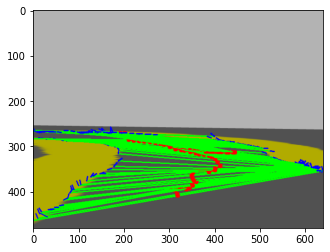

In [444]:
img = image()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
filter_img = (filter(hsv) * 255).astype(np.uint8)
edges = cv2.Canny(filter_img, 200, 240)

mark_road(img, edges, dist=10, max_iter=100)
show(img)